In [1]:
!hostname
!pwd

dhcp-10-29-252-228.dyn.MIT.EDU
/Users/akarshkumar0101/synthetic-mdps/src


In [2]:
# This is autoreload module code using jupyter magic
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import os
from tqdm.auto import tqdm
import glob
import matplotlib

from einops import rearrange, repeat

In [4]:

def plot_curve_lines(x, y, c="r", **kwargs):  # x.shape=(t, ), y.shape = (n, t)
    c = matplotlib.colors.to_rgba(c)
    plt.plot(x, y.mean(axis=0), c=c, **kwargs)
    c = [c[0], c[1], c[2], .1]
    plt.plot(x, y.T, c=c)

def plot_curve_err(x, y, c="r", **kwargs):  # x.shape=(t, ), y.shape = (n, t)
    c = matplotlib.colors.to_rgba(c)
    mean, std = y.mean(axis=0), y.std(axis=0)
    err = std/np.sqrt(y.shape[0])
    plt.plot(x, mean, c=c, **kwargs)
    c = [c[0], c[1], c[2], .1]
    plt.fill_between(x, mean-err, mean+err, color=c)


In [5]:
def viz_training(load_dir):
    print(load_dir)
    with open(f"{load_dir}/config.json", "r") as f:
        config = json.load(f)
    with open(f"{load_dir}/rew.pkl", "rb") as f:
        rew = np.asarray(pickle.load(f)) # (s, n, t, e)
    rets = rew.sum(axis=-2).mean(axis=-1)
    print(rets.shape)
    
    plt.figure(figsize=(10, 5))
    # plot_curve_lines(np.arange(rets.shape[-1]), rets, c="r")
    plot_curve_err(np.arange(rets.shape[-1]), rets, c="r")
    
    plt.title(f"Pretraining Env:\n{config['env_id']}")
    plt.ylabel('Single Episode Return')
    plt.xlabel('Training Steps')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'{args.save_dir}/plot_pretrain.png')
    # plt.close()

    
viz_training("../data/train/name=cartpole;fobs=T;tl=128")


../data/train/name=cartpole;fobs=T;tl=128


FileNotFoundError: [Errno 2] No such file or directory: '../data/train/name=cartpole;fobs=T;tl=128/config.json'

../data/eval/name=acrobot;fobs=T;tl=128
{'act': (8, 128, 128), 'done': (8, 128, 128), 'env_state': {'env_state': EnvState(joint_angle1=(8, 128, 128), joint_angle2=(8, 128, 128), velocity_1=(8, 128, 128), velocity_2=(8, 128, 128), time=(8, 128, 128)), 'time': (8, 128, 128)}, 'info': {'base_env_state': EnvState(joint_angle1=(8, 128, 128), joint_angle2=(8, 128, 128), velocity_1=(8, 128, 128), velocity_2=(8, 128, 128), time=(8, 128, 128)), 'discount': (8, 128, 128)}, 'log_prob': (8, 128, 128), 'logits': (8, 128, 128, 3), 'obs': {'act_p': (8, 128, 128), 'done': (8, 128, 128), 'obs': (8, 128, 128, 6), 'rew_p': (8, 128, 128)}, 'rew': (8, 128, 128), 'val': (8, 128, 128)}
EnvState(joint_angle1=(8, 128, 128), joint_angle2=(8, 128, 128), velocity_1=(8, 128, 128), velocity_2=(8, 128, 128), time=(8, 128, 128))


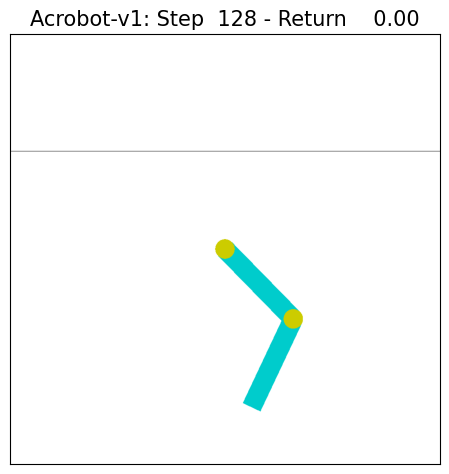

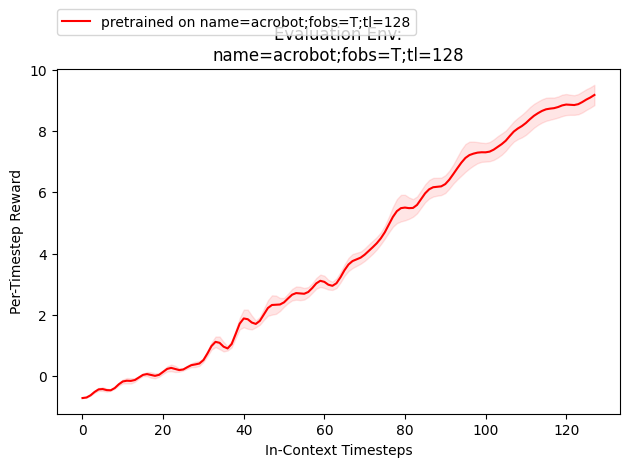

In [14]:

def viz_eval(load_dir):
    print(load_dir)
    eval_dirs = sorted([path for path in glob.glob(f"{load_dir}/*") if os.path.isdir(path)])
    assert len(eval_dirs) > 0
    # plt.figure(figsize=(10, 5))
    for i, eval_dir in enumerate(eval_dirs):
        with open(f"{eval_dir}/config.json", "r") as f:
            config = json.load(f)
        with open(f"{config['load_dir']}/config.json", "r") as f:
            config_pre = json.load(f)
        env, env_pre = config['env_id'], config_pre['env_id']

        with open(f"{eval_dir}/buffers.pkl", "rb") as f:
            buffers = jax.tree_map(lambda x: np.asarray(x), pickle.load(f))
        print(jax.tree_map(lambda x: x.shape, buffers[0]))
        env_state = buffers[0]['info']['base_env_state']
        print(jax.tree_map(lambda x: x.shape, env_state))
        from mdps.natural_mdps import CartPole, MountainCar, Acrobot
        e = Acrobot()
        env_params = e.default_params
        from gymnax.visualize import Visualizer
        state_seq = [jax.tree_map(lambda x: x[0, t, 0], env_state) for t in range(128)]
        cum_rewards = [0 for _ in state_seq]
        vis = Visualizer(e, env_params, state_seq, cum_rewards)
        vis.animate(f"{config['save_dir']}/anim.gif")
        
        
        plt.figure()
        with open(f'{eval_dir}/rew.pkl', 'rb') as f:
            rew = np.asarray(pickle.load(f)) # (s, n, t, e)
        rew = rew.mean(axis=(1, 3))
        plot_curve_err(np.arange(rew.shape[-1]), rew, c="r", label=f"pretrained on {env_pre}")
        
        # for i, env_pre in enumerate(sorted(os.listdir(f'../data/transfer/{env_trans}'))):
        #     with open(f'../data/transfer/{env_trans}/{env_pre}/rews_trained.pkl', 'rb') as f:
        #         rews_trained = np.asarray(pickle.load(f))
        #     plot_single(rews_trained, label=f"pretrained on {env_pre}", c=matplotlib.colors.to_rgba(colors[i]))
        # with open(f'../data/transfer/{env_trans}/{env_pre}/rews_init.pkl', 'rb') as f:
        #     rews_init = np.asarray(pickle.load(f))
        # plot_single(rews_init, label='init', c=matplotlib.colors.to_rgba('black'))
    plt.title(f'Evaluation Env:\n{env}')
    plt.ylabel('Per-Timestep Reward')
    plt.xlabel('In-Context Timesteps')
    plt.legend(loc=(0., 1.1))
    plt.tight_layout()
    # plt.savefig(f'{args.save_dir}/plot_eval.png')

viz_eval("../data/eval/name=acrobot;fobs=T;tl=128")

In [8]:
!ls ../data/eval

name=acrobot;fobs=T;tl=128     name=mountaincar;fobs=T;tl=128
name=cartpole;fobs=T;tl=128


In [10]:
!ls "../data/transfer/name=gridenv;grid_len=8;fobs=T;rpo=64;tl=128/name=gridenv;grid_len=8;fobs=T;rpo=64;tl=128"

buffers.pkl  config.json  rew.pkl


In [96]:
with open("../data/transfer/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128/name=gridenv;grid_len=8;pos_start=random;pos_rew=random;fobs=T;tl=128/buffers.pkl", "rb") as f:
    buffers = jax.tree_map(lambda x: jnp.asarray(x), pickle.load(f))

In [97]:
buffers[0].keys()

dict_keys(['act', 'done', 'env_state', 'info', 'log_prob', 'logits', 'obs', 'rew', 'val'])

In [90]:
d = np.stack([b['info']['goal_dist'] for b in buffers], axis=1)
d.shape

(8, 10, 128, 128)

(0.0, 9.0)

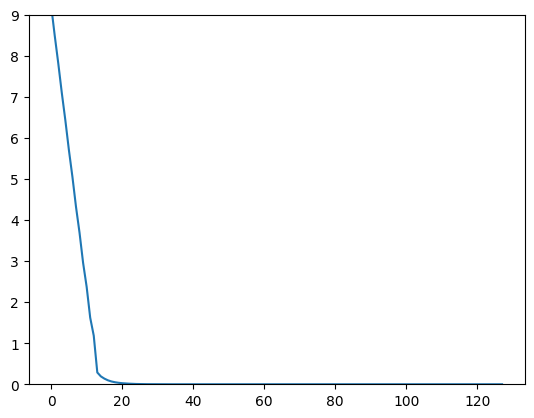

In [93]:
plt.plot(d.mean(axis=(0, 1, 3)))
plt.ylim(0, 9)